# Install Requirements

In [64]:
!pip install -r "/content/sample_data/requirements.txt"

# Import Libraries

In [2]:
import torch
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
import numpy as np
from sklearn.metrics import classification_report
import gradio as gr

In [3]:
print(torch.cuda.is_available())

True


# Load Data

In [4]:
data = load_dataset("imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

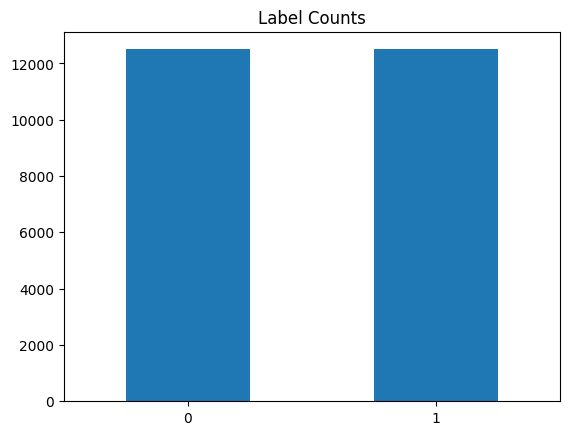

In [6]:
pd.Series(data['train']['label']).value_counts().plot(kind='bar',title='Label Counts',rot = 0)
plt.show()

In [7]:
data['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [8]:
pd.Series(data['test']['label']).value_counts()

,count
0,12500
1,12500


# Using twitter-roberta-base-sentiment-latest

In [9]:
MODEL_PATH = "cardiffnlp/twitter-roberta-base-sentiment-latest"
DEVICE = "cuda:0"
roberta_pipe  = pipeline(
    model = MODEL_PATH,
    tokenizer = MODEL_PATH,
    top_k=None,
    device = DEVICE
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [10]:
print(roberta_pipe .model.config.id2label)

{0: 'negative', 1: 'neutral', 2: 'positive'}


In [11]:
data['test'][0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

In [12]:
roberta_pipe (data['test'][0]['text'])

[[{'label': 'negative', 'score': 0.415335476398468},
  {'label': 'neutral', 'score': 0.3235189616680145},
  {'label': 'positive', 'score': 0.26114556193351746}]]

In [13]:
LABEL_ORDER = ['negative', 'neutral', 'positive']
def get_sentiment_score(output):
    scores = {x['label']: x['score'] for x in output}
    return [scores[label] for label in LABEL_ORDER]

In [14]:
y_pred  = []
for x in roberta_pipe (KeyDataset(data["test"],"text"), truncation=True, max_length=512, padding=True):
  neg_score,_,pos_score = get_sentiment_score(x)
  y_pred.append(0 if neg_score > pos_score else 1)

In [15]:
def evaluate(y_true,y_pred):
  evaluation_report = classification_report(y_true, y_pred,target_names=["Negative Review", "Positive Review"])
  print(evaluation_report)

In [16]:
roberta_report = evaluate(data["test"]["label"],y_pred)

                 precision    recall  f1-score   support

Negative Review       0.80      0.83      0.81     12500
Positive Review       0.82      0.79      0.81     12500

       accuracy                           0.81     25000
      macro avg       0.81      0.81      0.81     25000
   weighted avg       0.81      0.81      0.81     25000



In [18]:
pd.Series(y_pred).value_counts()

,count
0,12961
1,12039


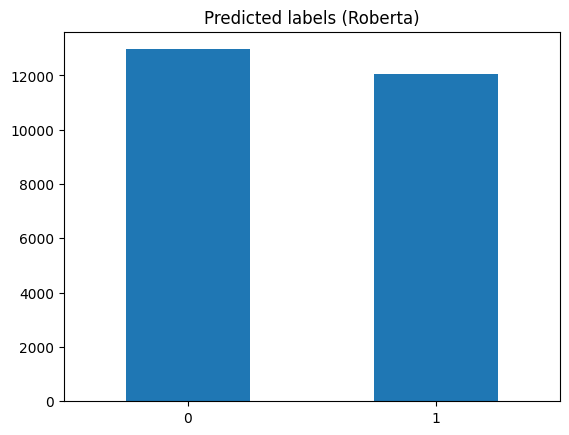

In [19]:
pd.Series(y_pred).value_counts().plot(kind = 'bar',title='Predicted labels (Roberta)',rot=0)
plt.show()

# Using distilbert-base-uncased-finetuned-sst-2-english

In [20]:
MODEL_PATH = "distilbert-base-uncased-finetuned-sst-2-english"
distilbert_pipe = pipeline(
    model = MODEL_PATH,
    tokenizer = MODEL_PATH,
    device = DEVICE,
    top_k=None
)

Device set to use cuda:0


In [21]:
print(distilbert_pipe.model.config.id2label)

{0: 'NEGATIVE', 1: 'POSITIVE'}


In [22]:
LABEL_ORDER = ['NEGATIVE', 'POSITIVE']
def get_sentiment_score(output):
    scores = {x['label']: x['score'] for x in output}
    return [scores[label] for label in LABEL_ORDER]

In [23]:
y_pred  = []
for x in distilbert_pipe(KeyDataset(data["test"],"text"),truncation=True, max_length=512, padding=True):
  neg_score,pos_score = get_sentiment_score(x)
  y_pred.append(0 if neg_score > pos_score else 1)

In [24]:
distilbert_report = evaluate(data["test"]["label"],y_pred)

                 precision    recall  f1-score   support

Negative Review       0.87      0.92      0.89     12500
Positive Review       0.91      0.86      0.89     12500

       accuracy                           0.89     25000
      macro avg       0.89      0.89      0.89     25000
   weighted avg       0.89      0.89      0.89     25000



In [26]:
pd.Series(y_pred).value_counts()

,count
0,13220
1,11780


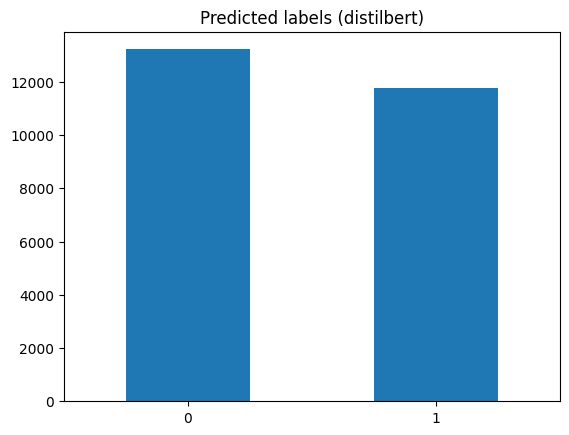

In [27]:
pd.Series(y_pred).value_counts().plot(kind = 'bar',title='Predicted labels (distilbert)',rot=0)
plt.show()

# Create a demo

In [70]:
def analyze_sentiment(text):
        result = distilbert_pipe(text,truncation=True, max_length=512, padding=True)
        y_pred = result[0][0].get('label')
        return f"Predicted sentiment: {y_pred}"

In [74]:
text_example = data['test'][0]['text']
true_label = data['test'][0]['label']
print(analyze_sentiment(text_example))
print(f'True sentiment : {"NEGATIVE" if true_label == 0 else "POSITIVE"}')

Predicted sentiment: NEGATIVE
True sentiment : NEGATIVE


In [63]:
iface = gr.Interface(
    fn=analyze_sentiment,
    inputs=[
        gr.Textbox(label="Input Text"),
    ],
    outputs=gr.Label(label="Sentiment Analysis Result"),
    title="Sentiment Analysis",
    description="Discover the emotional tone of any text with cutting-edge AI!"
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d38f78e686f503d120.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
